In [26]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.image as Image
import matplotlib.pyplot as plt
import math
import time
import tqdm
import sys
import pickle

In [27]:
# Ciphertext Class which contains ciphertext and its dimension
class CipherText:
    def __init__(self, ciphertext, dimension):
        self.ciphertext = ciphertext
        self.dimension = dimension

In [28]:
# AES Implementation
class AES:
    # constructor for AES which stores some useful matrices
    def __init__(self):
        self.numberOfRounds=10
        self.substitutionBlock=np.genfromtxt('substitution_block.csv',dtype=np.int64)
        self.invSubstitutionBlock=np.genfromtxt('inv_subs_block.csv',dtype=np.int64)
        self.mul2=np.genfromtxt('mul2.csv',dtype=np.int64)
        self.mul3=np.genfromtxt('mul3.csv',dtype=np.int64)
        self.mul9=np.genfromtxt('mul9.csv',dtype=np.int64)
        self.mul11=np.genfromtxt('mul11.csv',dtype=np.int64)
        self.mul13=np.genfromtxt('mul13.csv',dtype=np.int64)
        self.mul14=np.genfromtxt('mul14.csv',dtype=np.int64)
        self.key_xor=np.genfromtxt('key_xor.csv',dtype=np.int64)
    
    # transforms the key by taking xor and using g function
    def transformKey(self,nibble,pos):
        temp=nibble[0]
        for i in range(0,3):
            nibble[i]=nibble[i+1]
        nibble[3]=temp

        for i in range(0,4):
            nibble[i]=self.substitutionBlock[nibble[i]]

        nibble[0]^=self.key_xor[pos]
        return nibble
    
    # Generate the key for all 10 rounds
    def keyExpansion(self,key):
        expandedKey=np.zeros(176,dtype=np.int64)
        expandedKey[0:16]=key
        for i in range(16,176,4):
            temp=expandedKey[i-4:i]
            if i%16==0:
                temp=self.transformKey(temp,i//16)
            expandedKey[i:i+4]=np.bitwise_xor(expandedKey[i-16:i-12],temp)
        return expandedKey
    
    # Substitute Bytes Operation
    def substituteBytes(self,block):
        for i in range(0,4):
            for j in range(0,4):
                block[i][j]=self.substitutionBlock[block[i][j]]
    
    # Shift Rows Operation
    def shiftRows(self,block):
        block[1,0],block[1,1],block[1,2],block[1,3] = block[1,1],block[1,2],block[1,3],block[1,0]
        block[2,0],block[2,1],block[2,2],block[2,3] = block[2,2],block[2,3],block[2,0],block[2,1]
        block[3,0],block[3,1],block[3,2],block[3,3] = block[3,3],block[3,0],block[3,1],block[3,2]

    # Mix column Operation
    def mixColumns(self,block):
        answer=np.zeros((4,4))
        for i in range(0,4):
            answer[0][i]=self.mul2[block[0][i]]^self.mul3[block[1][i]]^block[2][i]^block[3][i]
        for i in range(0,4):
            answer[1][i]=block[0][i]^self.mul2[block[1][i]]^self.mul3[block[2][i]]^block[3][i]
        for i in range(0,4):
            answer[2][i]=block[0][i]^block[1][i]^self.mul2[block[2][i]]^self.mul3[block[3][i]]
        for i in range(0,4):
            answer[3][i]=self.mul3[block[0][i]]^block[1][i]^block[2][i]^self.mul2[block[3][i]]
        block=answer
    
    # Add Round Key
    def addRoundKey(self,block,roundKey):
        block=np.bitwise_xor(block,roundKey)
        return block
    
    # Encrypts the plaintext and returns ciphertext object
    def encrypt(self,image,key):
        img=Image.imread(image)
        dimension=np.asarray(img.shape)
        img=img.reshape(-1,)
        while img.shape[0]%16!=0:
            img=np.append(img,[0])
        answer=np.ones(img.shape[0])
        expandedKey=self.keyExpansion(key)
        for i in tqdm.tqdm(range(0,img.shape[0],16)):
            block=img[i:i+16].reshape((4,4))
            self.addRoundKey(block,expandedKey[0:16].reshape((4,4)))
            for j in range(0,self.numberOfRounds-1):
                self.substituteBytes(block)
                self.shiftRows(block)
                self.mixColumns(block)
                self.addRoundKey(block,expandedKey[(j+1)*16:(j+2)*16].reshape((4,4)))
            self.substituteBytes(block)
            self.shiftRows(block)
            self.addRoundKey(block,expandedKey[160:176].reshape((4,4)))
            answer[i:i+16]=block.reshape(-1,)
        answer=CipherText(answer.astype(int),dimension)
        return answer
    
    # Inverse Substitue Bytes
    def invSubstituteBytes(self,block):
        for i in range(0,4):
            for j in range(0,4):
                block[i][j]=self.invSubstitutionBlock[block[i][j]]

    # Inverse Shift Rows     
    def shiftBackRows(self,block):
        block[1,0],block[1,1],block[1,2],block[1,3] = block[1,3],block[1,0],block[1,1],block[1,2]
        block[2,0],block[2,1],block[2,2],block[2,3] = block[2,2],block[2,3],block[2,0],block[2,1]
        block[3,0],block[3,1],block[3,2],block[3,3] = block[3,1],block[3,2],block[3,3],block[3,0]

    # Inverse Mix Columns   
    def invMixColumns(self,block):
        answer=np.zeros((4,4))
        for i in range(0,4):
            answer[i][0]=self.mul14[block[i][0]]^self.mul11[block[i][1]]^self.mul13[block[i][2]]^self.mul9[block[i][3]]
        for i in range(0,4):
            answer[i][1]=self.mul9[block[i][0]]^self.mul14[block[i][1]]^self.mul11[block[i][2]]^self.mul13[block[i][3]]
        for i in range(0,4):
            answer[i][2]=self.mul13[block[i][0]]^self.mul9[block[i][1]]^self.mul14[block[i][2]]^self.mul11[block[i][3]]
        for i in range(0,4):
            answer[i][3]=self.mul11[block[i][0]]^self.mul13[block[i][1]]^self.mul9[block[i][2]]^self.mul14[block[i][3]]
        block=answer
    
    # Decrypts the ciphertext and returns the image pixel vector
    def decrypt(self,ciphertext,key):
        dimension=ciphertext.dimension
        ciphertext=ciphertext.ciphertext
        answer=np.ones(ciphertext.shape[0])
        expandedKey=self.keyExpansion(key)
        for i in tqdm.tqdm(range(0,ciphertext.shape[0],16)):
            block=ciphertext[i:i+16].reshape((4,4))
            self.addRoundKey(block,expandedKey[160:176].reshape((4,4)))
            for j in range(0,self.numberOfRounds-1):
                self.shiftBackRows(block)
                self.invSubstituteBytes(block)
                self.addRoundKey(block,expandedKey[160-16*(j+1):176-16*(j+1)].reshape((4,4)))
                self.invMixColumns(block)
            self.shiftBackRows(block)
            self.invSubstituteBytes(block)
            self.addRoundKey(block,expandedKey[0:16].reshape((4,4)))
            answer[i:i+16]=block.reshape(-1,)
        return answer[0:dimension[0]*dimension[1]*dimension[2]].reshape(dimension).astype(int)
     

In [29]:
# Generate a random key
key=np.random.randint(0,255,16)

In [30]:
# Image to be encrypted
img='groot.jpg'
vector=Image.imread(img)

# shape of image pixel vector
print(vector.shape)
print(vector)

(1332, 749, 3)
[[[16 17 11]
  [19 20 14]
  [20 21 15]
  ...
  [54 46 25]
  [54 46 25]
  [58 50 29]]

 [[16 17 11]
  [18 19 13]
  [20 21 15]
  ...
  [51 43 22]
  [51 43 22]
  [53 45 24]]

 [[15 16 10]
  [17 18 12]
  [19 20 14]
  ...
  [46 38 17]
  [46 38 17]
  [49 41 20]]

 ...

 [[21 17 14]
  [18 14 11]
  [16 12  9]
  ...
  [16 15 11]
  [16 15 11]
  [28 23 19]]

 [[20 16 13]
  [16 12  9]
  [15 11  8]
  ...
  [17 16 12]
  [16 15 11]
  [27 22 18]]

 [[19 15 12]
  [16 12  9]
  [14 10  7]
  ...
  [18 17 13]
  [15 14 10]
  [26 21 17]]]


In [31]:
# Creates an object of aes class
aes=AES()
cipherText=aes.encrypt(img,key)

100%|██████████| 187063/187063 [00:59<00:00, 3121.21it/s]


In [32]:
# Ciphertext shape and ciphertext
print(cipherText.dimension.shape)
print(cipherText.ciphertext)

(3,)
[243 248 110 ...  54  54  54]


[ 39  97 216 110  50  20 163 151  60  67 225 163  48  32  14 230]


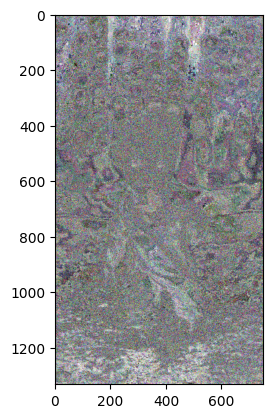

In [33]:
# Image formed by ciphertext
cipherImg=cipherText.ciphertext[0:np.product(cipherText.dimension)].reshape(cipherText.dimension)
plt.imshow(cipherImg)
print(key)

In [34]:
# decrypt the ciphertext
plaintext=aes.decrypt(cipherText,key)

100%|██████████| 187063/187063 [01:00<00:00, 3117.23it/s]


In [35]:
# Plaintext shape and plaintext
print(plaintext.shape)
print(plaintext)

(1332, 749, 3)
[[[16 17 11]
  [19 20 14]
  [20 21 15]
  ...
  [54 46 25]
  [54 46 25]
  [58 50 29]]

 [[16 17 11]
  [18 19 13]
  [20 21 15]
  ...
  [51 43 22]
  [51 43 22]
  [53 45 24]]

 [[15 16 10]
  [17 18 12]
  [19 20 14]
  ...
  [46 38 17]
  [46 38 17]
  [49 41 20]]

 ...

 [[21 17 14]
  [18 14 11]
  [16 12  9]
  ...
  [16 15 11]
  [16 15 11]
  [28 23 19]]

 [[20 16 13]
  [16 12  9]
  [15 11  8]
  ...
  [17 16 12]
  [16 15 11]
  [27 22 18]]

 [[19 15 12]
  [16 12  9]
  [14 10  7]
  ...
  [18 17 13]
  [15 14 10]
  [26 21 17]]]


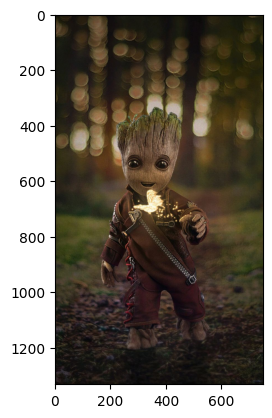

In [37]:
# image which was encrypted
plt.imshow(plaintext)